# Import Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import numpy as np
import math
import tqdm
import threading

# Image Processing

(225, 225, 3)


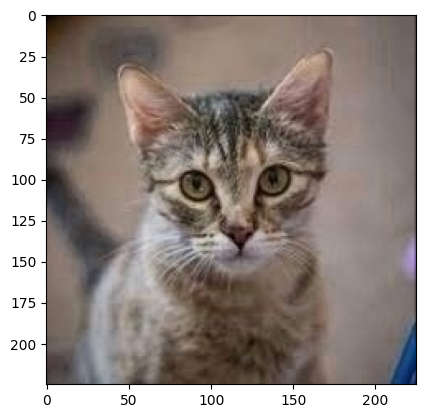

In [2]:
img_str = "Cat.jpeg"
img2 = image.load_img(img_str)
plt.imshow(img2)

im = cv2.imread(img_str) 
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #Convert image data from BGR to RGB
cv2.imwrite(img_str , img) 
(d0,d1,d2) = img.shape # Image dimensions

print(img.shape)

# Image to Byte Matrix conversion including padding

In [3]:

def make_msg(msg):
    (d0,d1,d2) = msg.shape
    n_chunks = math.ceil(d0*d1*d2/16)
    # print("Number of chunks: ", end = "")
    # print(n_chunks)
    padding_len = 16 - (d0*d1*d2%16)
    # print("padding length: ", end = "")
    # print(padding_len)
    arr = msg.reshape(-1)
    for i in range(padding_len%16):
        arr = np.append(arr,padding_len)
    msg = arr.reshape(n_chunks,4,4)
    return msg

# Byte Matrix to Image Conversion

In [4]:
def make_img(msg):
    padding_len = 16 - (d0*d1*d2%16)
    for i in range(padding_len%16):
        (len,) = msg.shape
        msg = np.delete(msg,len-1)
    img = msg.reshape(d0,d1,d2)
    return img

# Intial Matrices 

In [5]:
# Substitution Block
sBox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16])

# Inverse Substitution Block
inv_s_box = np.array([
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,]
)

# Galois field Multiplication with 2
# GaloisF2 = np.array([
#     0x00, 0x02, 0x04, 0x06, 0x08, 0x0a, 0x0c, 0x0e, 0x10, 0x12, 0x14, 0x16, 0x18, 0x1a, 0x1c, 0x1e,
#     0x20, 0x22, 0x24, 0x26, 0x28, 0x2a, 0x2c, 0x2e, 0x30, 0x32, 0x34, 0x36, 0x38, 0x3a, 0x3c, 0x3e,
#     0x40, 0x42, 0x44, 0x46, 0x48, 0x4a, 0x4c, 0x4e, 0x50, 0x52, 0x54, 0x56, 0x58, 0x5a, 0x5c, 0x5e,
#     0x60, 0x62, 0x64, 0x66, 0x68, 0x6a, 0x6c, 0x6e, 0x70, 0x72, 0x74, 0x76, 0x78, 0x7a, 0x7c, 0x7e,
#     0x80, 0x82, 0x84, 0x86, 0x88, 0x8a, 0x8c, 0x8e, 0x90, 0x92, 0x94, 0x96, 0x98, 0x9a, 0x9c, 0x9e,
#     0xa0, 0xa2, 0xa4, 0xa6, 0xa8, 0xaa, 0xac, 0xae, 0xb0, 0xb2, 0xb4, 0xb6, 0xb8, 0xba, 0xbc, 0xbe,
#     0xc0, 0xc2, 0xc4, 0xc6, 0xc8, 0xca, 0xcc, 0xce, 0xd0, 0xd2, 0xd4, 0xd6, 0xd8, 0xda, 0xdc, 0xde,
#     0xe0, 0xe2, 0xe4, 0xe6, 0xe8, 0xea, 0xec, 0xee, 0xf0, 0xf2, 0xf4, 0xf6, 0xf8, 0xfa, 0xfc, 0xfe,
#     0x1b, 0x19, 0x1f, 0x1d, 0x13, 0x11, 0x17, 0x15, 0x0b, 0x09, 0x0f, 0x0d, 0x03, 0x01, 0x07, 0x05,
#     0x3b, 0x39, 0x3f, 0x3d, 0x33, 0x31, 0x37, 0x35, 0x2b, 0x29, 0x2f, 0x2d, 0x23, 0x21, 0x27, 0x25,
#     0x5b, 0x59, 0x5f, 0x5d, 0x53, 0x51, 0x57, 0x55, 0x4b, 0x49, 0x4f, 0x4d, 0x43, 0x41, 0x47, 0x45,
#     0x7b, 0x79, 0x7f, 0x7d, 0x73, 0x71, 0x77, 0x75, 0x6b, 0x69, 0x6f, 0x6d, 0x63, 0x61, 0x67, 0x65,
#     0x9b, 0x99, 0x9f, 0x9d, 0x93, 0x91, 0x97, 0x95, 0x8b, 0x89, 0x8f, 0x8d, 0x83, 0x81, 0x87, 0x85,
#     0xbb, 0xb9, 0xbf, 0xbd, 0xb3, 0xb1, 0xb7, 0xb5, 0xab, 0xa9, 0xaf, 0xad, 0xa3, 0xa1, 0xa7, 0xa5,
#     0xdb, 0xd9, 0xdf, 0xdd, 0xd3, 0xd1, 0xd7, 0xd5, 0xcb, 0xc9, 0xcf, 0xcd, 0xc3, 0xc1, 0xc7, 0xc5,
#     0xfb, 0xf9, 0xff, 0xfd, 0xf3, 0xf1, 0xf7, 0xf5, 0xeb, 0xe9, 0xef, 0xed, 0xe3, 0xe1, 0xe7, 0xe5])

# # Galois field Multiplication with 3
# GaloisF3 = np.array([
#     0x00, 0x03, 0x06, 0x05, 0x0c, 0x0f, 0x0a, 0x09, 0x18, 0x1b, 0x1e, 0x1d, 0x14, 0x17, 0x12, 0x11,
#     0x30, 0x33, 0x36, 0x35, 0x3c, 0x3f, 0x3a, 0x39, 0x28, 0x2b, 0x2e, 0x2d, 0x24, 0x27, 0x22, 0x21,
#     0x60, 0x63, 0x66, 0x65, 0x6c, 0x6f, 0x6a, 0x69, 0x78, 0x7b, 0x7e, 0x7d, 0x74, 0x77, 0x72, 0x71,
#     0x50, 0x53, 0x56, 0x55, 0x5c, 0x5f, 0x5a, 0x59, 0x48, 0x4b, 0x4e, 0x4d, 0x44, 0x47, 0x42, 0x41,
#     0xc0, 0xc3, 0xc6, 0xc5, 0xcc, 0xcf, 0xca, 0xc9, 0xd8, 0xdb, 0xde, 0xdd, 0xd4, 0xd7, 0xd2, 0xd1,
#     0xf0, 0xf3, 0xf6, 0xf5, 0xfc, 0xff, 0xfa, 0xf9, 0xe8, 0xeb, 0xee, 0xed, 0xe4, 0xe7, 0xe2, 0xe1,
#     0xa0, 0xa3, 0xa6, 0xa5, 0xac, 0xaf, 0xaa, 0xa9, 0xb8, 0xbb, 0xbe, 0xbd, 0xb4, 0xb7, 0xb2, 0xb1,
#     0x90, 0x93, 0x96, 0x95, 0x9c, 0x9f, 0x9a, 0x99, 0x88, 0x8b, 0x8e, 0x8d, 0x84, 0x87, 0x82, 0x81,
#     0x9b, 0x98, 0x9d, 0x9e, 0x97, 0x94, 0x91, 0x92, 0x83, 0x80, 0x85, 0x86, 0x8f, 0x8c, 0x89, 0x8a,
#     0xab, 0xa8, 0xad, 0xae, 0xa7, 0xa4, 0xa1, 0xa2, 0xb3, 0xb0, 0xb5, 0xb6, 0xbf, 0xbc, 0xb9, 0xba,
#     0xfb, 0xf8, 0xfd, 0xfe, 0xf7, 0xf4, 0xf1, 0xf2, 0xe3, 0xe0, 0xe5, 0xe6, 0xef, 0xec, 0xe9, 0xea,
#     0xcb, 0xc8, 0xcd, 0xce, 0xc7, 0xc4, 0xc1, 0xc2, 0xd3, 0xd0, 0xd5, 0xd6, 0xdf, 0xdc, 0xd9, 0xda,
#     0x5b, 0x58, 0x5d, 0x5e, 0x57, 0x54, 0x51, 0x52, 0x43, 0x40, 0x45, 0x46, 0x4f, 0x4c, 0x49, 0x4a,
#     0x6b, 0x68, 0x6d, 0x6e, 0x67, 0x64, 0x61, 0x62, 0x73, 0x70, 0x75, 0x76, 0x7f, 0x7c, 0x79, 0x7a,
#     0x3b, 0x38, 0x3d, 0x3e, 0x37, 0x34, 0x31, 0x32, 0x23, 0x20, 0x25, 0x26, 0x2f, 0x2c, 0x29, 0x2a,
#     0x0b, 0x08, 0x0d, 0x0e, 0x07, 0x04, 0x01, 0x02, 0x13, 0x10, 0x15, 0x16, 0x1f, 0x1c, 0x19, 0x1a
# ])

# # Galois field Multiplication with 9
# GaloisF9 = np.array([
#      0x00, 0x09, 0x12, 0x1b, 0x24, 0x2d, 0x36, 0x3f, 0x48, 0x41, 0x5a, 0x53, 0x6c, 0x65, 0x7e, 0x77,
#      0x90, 0x99, 0x82, 0x8b, 0xb4, 0xbd, 0xa6, 0xaf, 0xd8, 0xd1, 0xca, 0xc3, 0xfc, 0xf5, 0xee, 0xe7,
#      0x3b, 0x32, 0x29, 0x20, 0x1f, 0x16, 0x0d, 0x04, 0x73, 0x7a, 0x61, 0x68, 0x57, 0x5e, 0x45, 0x4c,
#      0xab, 0xa2, 0xb9, 0xb0, 0x8f, 0x86, 0x9d, 0x94, 0xe3, 0xea, 0xf1, 0xf8, 0xc7, 0xce, 0xd5, 0xdc,
#      0x76, 0x7f, 0x64, 0x6d, 0x52, 0x5b, 0x40, 0x49, 0x3e, 0x37, 0x2c, 0x25, 0x1a, 0x13, 0x08, 0x01,
#      0xe6, 0xef, 0xf4, 0xfd, 0xc2, 0xcb, 0xd0, 0xd9, 0xae, 0xa7, 0xbc, 0xb5, 0x8a, 0x83, 0x98, 0x91,
#      0x4d, 0x44, 0x5f, 0x56, 0x69, 0x60, 0x7b, 0x72, 0x05, 0x0c, 0x17, 0x1e, 0x21, 0x28, 0x33, 0x3a,
#      0xdd, 0xd4, 0xcf, 0xc6, 0xf9, 0xf0, 0xeb, 0xe2, 0x95, 0x9c, 0x87, 0x8e, 0xb1, 0xb8, 0xa3, 0xaa,
#      0xec, 0xe5, 0xfe, 0xf7, 0xc8, 0xc1, 0xda, 0xd3, 0xa4, 0xad, 0xb6, 0xbf, 0x80, 0x89, 0x92, 0x9b,
#      0x7c, 0x75, 0x6e, 0x67, 0x58, 0x51, 0x4a, 0x43, 0x34, 0x3d, 0x26, 0x2f, 0x10, 0x19, 0x02, 0x0b,
#      0xd7, 0xde, 0xc5, 0xcc, 0xf3, 0xfa, 0xe1, 0xe8, 0x9f, 0x96, 0x8d, 0x84, 0xbb, 0xb2, 0xa9, 0xa0,
#      0x47, 0x4e, 0x55, 0x5c, 0x63, 0x6a, 0x71, 0x78, 0x0f, 0x06, 0x1d, 0x14, 0x2b, 0x22, 0x39, 0x30,
#      0x9a, 0x93, 0x88, 0x81, 0xbe, 0xb7, 0xac, 0xa5, 0xd2, 0xdb, 0xc0, 0xc9, 0xf6, 0xff, 0xe4, 0xed,
#      0x0a, 0x03, 0x18, 0x11, 0x2e, 0x27, 0x3c, 0x35, 0x42, 0x4b, 0x50, 0x59, 0x66, 0x6f, 0x74, 0x7d,
#      0xa1, 0xa8, 0xb3, 0xba, 0x85, 0x8c, 0x97, 0x9e, 0xe9, 0xe0, 0xfb, 0xf2, 0xcd, 0xc4, 0xdf, 0xd6,
#      0x31, 0x38, 0x23, 0x2a, 0x15, 0x1c, 0x07, 0x0e, 0x79, 0x70, 0x6b, 0x62, 0x5d, 0x54, 0x4f, 0x46
# ])

# # Galois field Multiplication with 11
# GaloisF11 = np.array([
#      0x00, 0x0b, 0x16, 0x1d, 0x2c, 0x27, 0x3a, 0x31, 0x58, 0x53, 0x4e, 0x45, 0x74, 0x7f, 0x62, 0x69,
#      0xb0, 0xbb, 0xa6, 0xad, 0x9c, 0x97, 0x8a, 0x81, 0xe8, 0xe3, 0xfe, 0xf5, 0xc4, 0xcf, 0xd2, 0xd9,
#      0x7b, 0x70, 0x6d, 0x66, 0x57, 0x5c, 0x41, 0x4a, 0x23, 0x28, 0x35, 0x3e, 0x0f, 0x04, 0x19, 0x12,
#      0xcb, 0xc0, 0xdd, 0xd6, 0xe7, 0xec, 0xf1, 0xfa, 0x93, 0x98, 0x85, 0x8e, 0xbf, 0xb4, 0xa9, 0xa2,
#      0xf6, 0xfd, 0xe0, 0xeb, 0xda, 0xd1, 0xcc, 0xc7, 0xae, 0xa5, 0xb8, 0xb3, 0x82, 0x89, 0x94, 0x9f,
#      0x46, 0x4d, 0x50, 0x5b, 0x6a, 0x61, 0x7c, 0x77, 0x1e, 0x15, 0x08, 0x03, 0x32, 0x39, 0x24, 0x2f,
#      0x8d, 0x86, 0x9b, 0x90, 0xa1, 0xaa, 0xb7, 0xbc, 0xd5, 0xde, 0xc3, 0xc8, 0xf9, 0xf2, 0xef, 0xe4,
#      0x3d, 0x36, 0x2b, 0x20, 0x11, 0x1a, 0x07, 0x0c, 0x65, 0x6e, 0x73, 0x78, 0x49, 0x42, 0x5f, 0x54,
#      0xf7, 0xfc, 0xe1, 0xea, 0xdb, 0xd0, 0xcd, 0xc6, 0xaf, 0xa4, 0xb9, 0xb2, 0x83, 0x88, 0x95, 0x9e,
#      0x47, 0x4c, 0x51, 0x5a, 0x6b, 0x60, 0x7d, 0x76, 0x1f, 0x14, 0x09, 0x02, 0x33, 0x38, 0x25, 0x2e,
#      0x8c, 0x87, 0x9a, 0x91, 0xa0, 0xab, 0xb6, 0xbd, 0xd4, 0xdf, 0xc2, 0xc9, 0xf8, 0xf3, 0xee, 0xe5,
#      0x3c, 0x37, 0x2a, 0x21, 0x10, 0x1b, 0x06, 0x0d, 0x64, 0x6f, 0x72, 0x79, 0x48, 0x43, 0x5e, 0x55,
#      0x01, 0x0a, 0x17, 0x1c, 0x2d, 0x26, 0x3b, 0x30, 0x59, 0x52, 0x4f, 0x44, 0x75, 0x7e, 0x63, 0x68,
#      0xb1, 0xba, 0xa7, 0xac, 0x9d, 0x96, 0x8b, 0x80, 0xe9, 0xe2, 0xff, 0xf4, 0xc5, 0xce, 0xd3, 0xd8,
#      0x7a, 0x71, 0x6c, 0x67, 0x56, 0x5d, 0x40, 0x4b, 0x22, 0x29, 0x34, 0x3f, 0x0e, 0x05, 0x18, 0x13,
#      0xca, 0xc1, 0xdc, 0xd7, 0xe6, 0xed, 0xf0, 0xfb, 0x92, 0x99, 0x84, 0x8f, 0xbe, 0xb5, 0xa8, 0xa3
# ])

# # Galois field Multiplication with 13
# GaloisF13 = np.array([
#      0x00, 0x0d, 0x1a, 0x17, 0x34, 0x39, 0x2e, 0x23, 0x68, 0x65, 0x72, 0x7f, 0x5c, 0x51, 0x46, 0x4b,
#      0xd0, 0xdd, 0xca, 0xc7, 0xe4, 0xe9, 0xfe, 0xf3, 0xb8, 0xb5, 0xa2, 0xaf, 0x8c, 0x81, 0x96, 0x9b,
#      0xbb, 0xb6, 0xa1, 0xac, 0x8f, 0x82, 0x95, 0x98, 0xd3, 0xde, 0xc9, 0xc4, 0xe7, 0xea, 0xfd, 0xf0,
#      0x6b, 0x66, 0x71, 0x7c, 0x5f, 0x52, 0x45, 0x48, 0x03, 0x0e, 0x19, 0x14, 0x37, 0x3a, 0x2d, 0x20,
#      0x6d, 0x60, 0x77, 0x7a, 0x59, 0x54, 0x43, 0x4e, 0x05, 0x08, 0x1f, 0x12, 0x31, 0x3c, 0x2b, 0x26,
#      0xbd, 0xb0, 0xa7, 0xaa, 0x89, 0x84, 0x93, 0x9e, 0xd5, 0xd8, 0xcf, 0xc2, 0xe1, 0xec, 0xfb, 0xf6,
#      0xd6, 0xdb, 0xcc, 0xc1, 0xe2, 0xef, 0xf8, 0xf5, 0xbe, 0xb3, 0xa4, 0xa9, 0x8a, 0x87, 0x90, 0x9d,
#      0x06, 0x0b, 0x1c, 0x11, 0x32, 0x3f, 0x28, 0x25, 0x6e, 0x63, 0x74, 0x79, 0x5a, 0x57, 0x40, 0x4d,
#      0xda, 0xd7, 0xc0, 0xcd, 0xee, 0xe3, 0xf4, 0xf9, 0xb2, 0xbf, 0xa8, 0xa5, 0x86, 0x8b, 0x9c, 0x91,
#      0x0a, 0x07, 0x10, 0x1d, 0x3e, 0x33, 0x24, 0x29, 0x62, 0x6f, 0x78, 0x75, 0x56, 0x5b, 0x4c, 0x41,
#      0x61, 0x6c, 0x7b, 0x76, 0x55, 0x58, 0x4f, 0x42, 0x09, 0x04, 0x13, 0x1e, 0x3d, 0x30, 0x27, 0x2a,
#      0xb1, 0xbc, 0xab, 0xa6, 0x85, 0x88, 0x9f, 0x92, 0xd9, 0xd4, 0xc3, 0xce, 0xed, 0xe0, 0xf7, 0xfa,
#      0xb7, 0xba, 0xad, 0xa0, 0x83, 0x8e, 0x99, 0x94, 0xdf, 0xd2, 0xc5, 0xc8, 0xeb, 0xe6, 0xf1, 0xfc,
#      0x67, 0x6a, 0x7d, 0x70, 0x53, 0x5e, 0x49, 0x44, 0x0f, 0x02, 0x15, 0x18, 0x3b, 0x36, 0x21, 0x2c,
#      0x0c, 0x01, 0x16, 0x1b, 0x38, 0x35, 0x22, 0x2f, 0x64, 0x69, 0x7e, 0x73, 0x50, 0x5d, 0x4a, 0x47,
#      0xdc, 0xd1, 0xc6, 0xcb, 0xe8, 0xe5, 0xf2, 0xff, 0xb4, 0xb9, 0xae, 0xa3, 0x80, 0x8d, 0x9a, 0x97
# ])

# # Galois field Multiplication with 14
# GaloisF14 = np.array([
#      0x00, 0x0e, 0x1c, 0x12, 0x38, 0x36, 0x24, 0x2a, 0x70, 0x7e, 0x6c, 0x62, 0x48, 0x46, 0x54, 0x5a,
#      0xe0, 0xee, 0xfc, 0xf2, 0xd8, 0xd6, 0xc4, 0xca, 0x90, 0x9e, 0x8c, 0x82, 0xa8, 0xa6, 0xb4, 0xba,
#      0xdb, 0xd5, 0xc7, 0xc9, 0xe3, 0xed, 0xff, 0xf1, 0xab, 0xa5, 0xb7, 0xb9, 0x93, 0x9d, 0x8f, 0x81,
#      0x3b, 0x35, 0x27, 0x29, 0x03, 0x0d, 0x1f, 0x11, 0x4b, 0x45, 0x57, 0x59, 0x73, 0x7d, 0x6f, 0x61,
#      0xad, 0xa3, 0xb1, 0xbf, 0x95, 0x9b, 0x89, 0x87, 0xdd, 0xd3, 0xc1, 0xcf, 0xe5, 0xeb, 0xf9, 0xf7,
#      0x4d, 0x43, 0x51, 0x5f, 0x75, 0x7b, 0x69, 0x67, 0x3d, 0x33, 0x21, 0x2f, 0x05, 0x0b, 0x19, 0x17,
#      0x76, 0x78, 0x6a, 0x64, 0x4e, 0x40, 0x52, 0x5c, 0x06, 0x08, 0x1a, 0x14, 0x3e, 0x30, 0x22, 0x2c,
#      0x96, 0x98, 0x8a, 0x84, 0xae, 0xa0, 0xb2, 0xbc, 0xe6, 0xe8, 0xfa, 0xf4, 0xde, 0xd0, 0xc2, 0xcc,
#      0x41, 0x4f, 0x5d, 0x53, 0x79, 0x77, 0x65, 0x6b, 0x31, 0x3f, 0x2d, 0x23, 0x09, 0x07, 0x15, 0x1b,
#      0xa1, 0xaf, 0xbd, 0xb3, 0x99, 0x97, 0x85, 0x8b, 0xd1, 0xdf, 0xcd, 0xc3, 0xe9, 0xe7, 0xf5, 0xfb,
#      0x9a, 0x94, 0x86, 0x88, 0xa2, 0xac, 0xbe, 0xb0, 0xea, 0xe4, 0xf6, 0xf8, 0xd2, 0xdc, 0xce, 0xc0,
#      0x7a, 0x74, 0x66, 0x68, 0x42, 0x4c, 0x5e, 0x50, 0x0a, 0x04, 0x16, 0x18, 0x32, 0x3c, 0x2e, 0x20,
#      0xec, 0xe2, 0xf0, 0xfe, 0xd4, 0xda, 0xc8, 0xc6, 0x9c, 0x92, 0x80, 0x8e, 0xa4, 0xaa, 0xb8, 0xb6,
#      0x0c, 0x02, 0x10, 0x1e, 0x34, 0x3a, 0x28, 0x26, 0x7c, 0x72, 0x60, 0x6e, 0x44, 0x4a, 0x58, 0x56,
#      0x37, 0x39, 0x2b, 0x25, 0x0f, 0x01, 0x13, 0x1d, 0x47, 0x49, 0x5b, 0x55, 0x7f, 0x71, 0x63, 0x6d,
#      0xd7, 0xd9, 0xcb, 0xc5, 0xef, 0xe1, 0xf3, 0xfd, 0xa7, 0xa9, 0xbb, 0xb5, 0x9f, 0x91, 0x83, 0x8d
# ])


# RCON table for ten rounds
RCON = [0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36]

# 16 Byte to 4x4 Matrix

In [6]:
def arr_to_mat(m):
    mat = m.reshape(4,4).T
    return mat


# Operation Functions

## Add Round Key

In [7]:
def add_round_key(msg,key):
    for i in range(4):
        for j in range(4):
             msg[i,j] ^= key[i,j]


## Substitute Bytes and its Inverse

In [8]:
def substitute_bytes(msg):
    for i in range(4):
        for j in range(4):
            msg[i,j] = sBox[msg[i,j]]

# Inverse Function
def inv_substitute_bytes(msg):
    for i in range(4):
        for j in range(4):
            msg[i,j] = inv_s_box[msg[i,j]]
            

## Shift Rows and its Inverse

In [9]:
def shift_rows(msg):
     msg[1,0],msg[1,1],msg[1,2],msg[1,3] = msg[1,1],msg[1,2],msg[1,3],msg[1,0]
     msg[2,0],msg[2,1],msg[2,2],msg[2,3] = msg[2,2],msg[2,3],msg[2,0],msg[2,1]
     msg[3,0],msg[3,1],msg[3,2],msg[3,3] = msg[3,3],msg[3,0],msg[3,1],msg[3,2]
        
# Inverse Function
def inv_shift_rows(msg):
     msg[1,0],msg[1,1],msg[1,2],msg[1,3] = msg[1,3],msg[1,0],msg[1,1],msg[1,2]
     msg[2,0],msg[2,1],msg[2,2],msg[2,3] = msg[2,2],msg[2,3],msg[2,0],msg[2,1]
     msg[3,0],msg[3,1],msg[3,2],msg[3,3] = msg[3,1],msg[3,2],msg[3,3],msg[3,0]
        

## Mix Columns and its Inverse

In [10]:

## Method-I - using galois field
# def mix_columns(msg):
#     for i in range(4):
#         x0 = GaloisF2[msg[0,i]]^GaloisF3[msg[1,i]]^[msg[2,i]]^[msg[3,i]]
#         x1 = [msg[0,i]]^GaloisF2[msg[1,i]]^GaloisF3[msg[2,i]]^[msg[3,i]]
#         x2 = [msg[0,i]]^GaloisF2[msg[2,i]]^GaloisF3[msg[3,i]]^[msg[1,i]]
#         x3 = GaloisF3[msg[0,i]]^[msg[1,i]]^[msg[2,i]]^GaloisF2[msg[3,i]]
#         msg[0,i],msg[1,i],msg[2,i],msg[3,i] = x0,x1,x2,x3

# def inv_mix_columns(msg):
#     for i in range(4):
#         x0 = GaloisF14[msg[0,i]]^GaloisF11[msg[1,i]]^GaloisF13[msg[2,i]]^GaloisF9[msg[3,i]]
#         x1 = GaloisF9[msg[0,i]]^GaloisF14[msg[1,i]]^GaloisF11[msg[2,i]]^GaloisF13[msg[3,i]]
#         x2 = GaloisF13[msg[0,i]]^GaloisF9[msg[1,i]]^GaloisF14[msg[2,i]]^GaloisF11[msg[3,i]]
#         x3 = GaloisF11[msg[0,i]]^GaloisF13[msg[1,i]]^GaloisF9[msg[2,i]]^GaloisF14[msg[3,i]]
#         msg[0,i],msg[1,i],msg[2,i],msg[3,i] = x0,x1,x2,x3       
        
## Method-II - using the algorithm given in the design of Rjindael
xtime = lambda a: (((a << 1) ^ 0x1B) & 0xFF) if (a & 0x80) else (a << 1)

# For single column
def mix_single_column(a):
    t = a[0] ^ a[1] ^ a[2] ^ a[3]
    u = a[0]
    a[0] ^= t ^ xtime(a[0] ^ a[1])
    a[1] ^= t ^ xtime(a[1] ^ a[2])
    a[2] ^= t ^ xtime(a[2] ^ a[3])
    a[3] ^= t ^ xtime(a[3] ^ u)


def mix_columns(msg):
    for i in range(4):
        a = np.array([msg[0,i],msg[1,i],msg[2,i],msg[3,i]])
        mix_single_column(a)
        msg[0,i],msg[1,i],msg[2,i],msg[3,i] = a[0],a[1],a[2],a[3]

# Inverse Function
def inv_mix_columns(msg):
    for i in range(4):
        u = xtime(xtime(msg[0,i] ^ msg[2,i]))
        v = xtime(xtime(msg[1,i] ^ msg[3,i]))
        msg[0,i] ^= u
        msg[1,i] ^= v
        msg[2,i] ^= u
        msg[3,i] ^= v

    mix_columns(msg)




# Key Expansion

In [11]:
# Function to take xor of 2 words(4 bytes)
def get_xor(a,b):
    c = np.array([0,0,0,0])
    for i in range(4):
        c[i] = a[i]^b[i]
    return c

# Function for rotation of a word
def byte_shift(a):
    c = np.array([0,0,0,0])
    c[0],c[1],c[2],c[3] = sBox[a[1]], sBox[a[2]], sBox[a[3]], sBox[a[0]]
    return c

# Main function for key expansion
def key_expansion(Key):
    expanded_key = Key
    for i in range(4,44):
        word_a = np.array([expanded_key[4*(i-4)], expanded_key[4*(i-4)+1], expanded_key[4*(i-4)+2], expanded_key[4*(i-4)+3]])
        word_b = np.array([expanded_key[4*(i-1)], expanded_key[4*(i-1)+1], expanded_key[4*(i-1)+2], expanded_key[4*(i-1)+3]])
        if(i%4==0):
            rcon = np.array([RCON[math.ceil(i/4)-1], 0x00, 0x00, 0x00])
            word_b = get_xor(byte_shift(word_b),rcon)
        word_c = get_xor(word_a,word_b)
        expanded_key = np.append(expanded_key, word_c)
    return expanded_key


# Encryption

In [12]:
# Key used for encryption
Key = np.array([0x16,0x62, 0x72, 0x00, 0x00, 0xB6, 0x76, 0x9e, 0x86, 0x36, 0x78, 0x8b, 0xc6, 0xf6, 0x5a, 0x27])

# Single Encryption Round
def encrypt_round(msg,key):
    substitute_bytes(msg)
    shift_rows(msg)
    mix_columns(msg)
    add_round_key(msg,key)


# Total Encryption of a msg with key in all rounds
def encryption(msg, key):
    key_mat = arr_to_mat(key[0:16])
    add_round_key(msg,key_mat)
    for i in range(9):
        encrypt_round(msg,arr_to_mat(key[16*(i+1):16*(i+2)]))
    substitute_bytes(msg)
    shift_rows(msg)
    add_round_key(msg,arr_to_mat(key[160:176]))
    cypher = msg.T.reshape(-1)
    return cypher

N_THREAD = 8

def threadrun(msg, key, value, threadcheckpoint, nchunks):
    for j in range(value*(nchunks//N_THREAD), (value+1)*(nchunks//N_THREAD)):
        val = encryption(msg[j].T, key)
        threadcheckpoint[j] = val
    return

# Final encryption function to encrypt all chunks of 4x4 matrices
def final_encryption(img, key):
    exp_key = key_expansion(key)
    msg = make_msg(img)
    n_chunks = math.ceil(d0*d1*d2/16)
    threadcheckpoint = []
    threadstore = []
    for i in range(n_chunks):
        threadcheckpoint.append(0)
    for i in range(N_THREAD):
        threadstore.append(0)
    cypher_text = np.zeros((16*n_chunks,), dtype = int) 

           
    for i in tqdm.tqdm(range(N_THREAD)):
        threadstore[i] = threading.Thread(target = threadrun,args = (msg, exp_key, i, threadcheckpoint, n_chunks))
    for i in tqdm.tqdm(range(N_THREAD)):
        threadstore[i].start()
    for i in tqdm.tqdm(range(N_THREAD)):
        threadstore[i].join()
    for i in tqdm.tqdm(range(n_chunks)):
        cypher_text[16*i:16*i+16] = threadcheckpoint[i]
        
    return cypher_text

cypher = final_encryption(img,Key)
# print(cypher)


100%|██████████| 9493/9493 [00:00<00:00, 1166750.51it/s]


## Encrypted Image

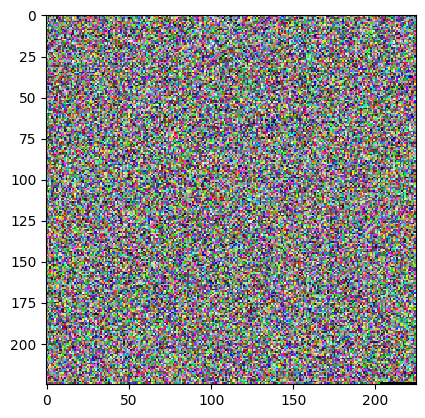

In [13]:
imgy = make_img(cypher)
plt.imshow(imgy, interpolation='nearest')
plt.show()

# Decryption

In [14]:
# Single Decryption Round
def decrypt_round(msg,key):
    inv_shift_rows(msg)
    inv_substitute_bytes(msg)
    add_round_key(msg,key)
    inv_mix_columns(msg)

# Total decryption of a msg with key in all rounds
def decryption(msg, key):
    key_mat = arr_to_mat(key[160:176])
    add_round_key(msg,key_mat)
    for i in range(9):
        decrypt_round(msg, arr_to_mat(key[160-16*(i+1):160-16*(i)]))
    inv_shift_rows(msg)
    inv_substitute_bytes(msg)
    add_round_key(msg,arr_to_mat(key[0:16]))
    decypher = msg.T.reshape(-1)
    return decypher


def threadrun(cypher, key, value, threadcheckpoint, nchunks):
    for j in range(value*(nchunks//N_THREAD), (value+1)*(nchunks//N_THREAD)):
        val = decryption(arr_to_mat(cypher[16*j:16*j+16]), key)
        threadcheckpoint[j] = val
    return

# Final decryption function to decrypt all chunks of 4x4 matrices
def final_decryption(cypher,key):
    exp_key = key_expansion(key)
    n_chunks = math.ceil(d0*d1*d2/16)
    threadcheckpoint = []
    threadstore = []
    for i in range(n_chunks):
        threadcheckpoint.append(0)
    for i in range(N_THREAD):
        threadstore.append(0)
    decypher_text = np.zeros((16*n_chunks,), dtype = int) 
    for i in tqdm.tqdm(range(N_THREAD)):
        threadstore[i] = threading.Thread(target = threadrun,args = (cypher, exp_key, i, threadcheckpoint, n_chunks))
    for i in tqdm.tqdm(range(N_THREAD)):
        threadstore[i].start()
    
    for i in tqdm.tqdm(range(N_THREAD)):
        threadstore[i].join()
    
    for i in tqdm.tqdm(range(n_chunks)):
        decypher_text[16*i:16*i+16] = threadcheckpoint[i]   


        
    return decypher_text

orig_img  = final_decryption(cypher,Key)

100%|██████████| 9493/9493 [00:00<00:00, 1190329.68it/s]


# Final Decrypted Image

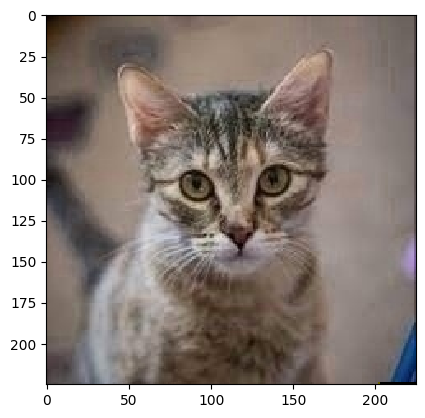

In [15]:
final_img = make_img(orig_img)
plt.imshow(final_img, interpolation='nearest')
plt.show()

## Converting back to original photo

In [16]:
im = cv2.imread(img_str)
img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cv2.imwrite(img_str , img)

True